# MovieLens-style Recommender (Synthetic Data, NDA‑Safe)

This notebook demonstrates a **two‑stage recommendation pipeline** similar to what you'd do on MovieLens:

1. **Candidate generation** via matrix factorization (implicit feedback) to score all items.
2. **Learning‑to‑rank reranking** using a Gradient Boosting Classifier on enriched features.
3. **Evaluation** using Recall@K and NDCG@K on a temporal validation split.

> **Why synthetic?** To keep this shareable and NDA‑safe, we generate a MovieLens‑like dataset with users, items, genres, implicit interactions, and timestamps. You can swap in MovieLens 100K/1M by loading the real CSVs in the same schema.


## 0) Setup

Imports and utility functions for metrics & evaluation.


In [1]:

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(42)

def recall_at_k(y_true, y_score, k):
    # y_true, y_score are arrays aligned by items for a user
    idx = np.argsort(-y_score)[:k]
    hits = y_true[idx].sum()
    total = y_true.sum()
    return float(hits) / float(total) if total > 0 else 0.0

def dcg_at_k(y_true, y_score, k):
    idx = np.argsort(-y_score)[:k]
    gains = y_true[idx] / np.log2(np.arange(2, len(idx)+2))
    return gains.sum()

def ndcg_at_k(y_true, y_score, k):
    dcg = dcg_at_k(y_true, y_score, k)
    ideal = dcg_at_k(y_true, y_true, k)  # ideal ranks positives first
    return float(dcg) / float(ideal) if ideal > 0 else 0.0


## 1) Build a Synthetic MovieLens‑like Dataset

We generate:
- **Users** with latent tastes
- **Items** with genres (one‑hot) and latent factors
- **Implicit interactions** (viewed = 1) over time


In [2]:

n_users = 1000
n_items = 800
n_genres = 5
density = 0.02  # ~2% of user-item pairs observed

# User latent tastes and item latent factors
rank = 30
user_latent = np.random.normal(0, 1, size=(n_users, rank))
item_latent = np.random.normal(0, 1, size=(n_items, rank))

# Genres and user genre preferences
item_genres = np.random.randint(0, n_genres, size=n_items)  # single-genre for simplicity
user_genre_pref = np.random.normal(0, 1, size=(n_users, n_genres))

# Base relevance score
base_scores = user_latent @ item_latent.T  # (n_users x n_items)

# Add genre affinity
genre_bonus = np.take_along_axis(user_genre_pref, item_genres[None, :], axis=1)  # (n_users x n_items)

# Combine and add noise
scores = 0.8*base_scores + 0.4*genre_bonus + 0.5*np.random.normal(0,1, size=(n_users, n_items))

# Turn into implicit positives with a threshold per-user to simulate watch behavior
thresholds = np.percentile(scores, 100*(1-density), axis=1, keepdims=True)
watched = (scores >= thresholds).astype(int)

# Build interactions DataFrame with timestamps
rows, cols = np.where(watched == 1)
timestamps = np.random.randint(1, 365, size=len(rows))  # day-of-year as timestamp proxy
interactions = pd.DataFrame({'user_id': rows, 'item_id': cols, 'ts': timestamps})

# Train/val split by time
t_split = 300  # first ~300 days train, last ~65 days validation
train = interactions[interactions['ts'] <= t_split].copy()
val = interactions[interactions['ts'] > t_split].copy()

train.shape, val.shape


((13211, 3), (2789, 3))

## 2) Candidate Generation with Matrix Factorization

We create a user‑item sparse matrix from **train** only, compute a truncated SVD (MF proxy), and score all items per user.


In [3]:

# Build user-item matrix from train
ui = sparse.coo_matrix(
    (np.ones(len(train)), (train['user_id'], train['item_id'])),
    shape=(n_users, n_items)
).tocsr()

# Truncated SVD (randomized) on the sparse matrix
k = 30
U, S, VT = randomized_svd(ui, n_components=k, random_state=42)
user_factors = U @ np.diag(S)       # (n_users x k)
item_factors = VT.T                 # (n_items x k)

# Compute base scores for all users and items
mf_scores = user_factors @ item_factors.T  # (n_users x n_items)

# Exclude items seen in train from candidate pool
train_seen = {}
for u in range(n_users):
    start_ptr, end_ptr = ui.indptr[u], ui.indptr[u+1]
    train_seen[u] = set(ui.indices[start_ptr:end_ptr])


## 3) Evaluate Candidate Generation (Recall@K / NDCG@K)

We evaluate against **validation** interactions only, for a random sample of users that have at least one validation interaction.


In [4]:

# Build validation labels per user as a binary vector over items
val_users = val['user_id'].unique()
np.random.shuffle(val_users)
eval_users = val_users[:200]  # evaluate a subset for speed

recall_list, ndcg_list = [], []
K = 10

# Precompute per-item popularity & genre for features later
item_pop = np.asarray(ui.sum(axis=0)).ravel()
item_genre_onehot = np.zeros((n_items, n_genres), dtype=int)
item_genre_onehot[np.arange(n_items), item_genres] = 1

for u in eval_users:
    y_true = np.zeros(n_items, dtype=int)
    y_true[val[val['user_id']==u]['item_id'].values] = 1
    scores_u = mf_scores[u]
    # Mask already-seen items in train
    if len(train_seen[u]) > 0:
        mask = np.ones(n_items, dtype=bool)
        mask[list(train_seen[u])] = False
        y_true_eval = y_true[mask]
        scores_eval = scores_u[mask]
    else:
        y_true_eval = y_true
        scores_eval = scores_u

    recall_list.append(recall_at_k(y_true_eval, scores_eval, K))
    ndcg_list.append(ndcg_at_k(y_true_eval, scores_eval, K))

mf_recall_k = float(np.mean(recall_list))
mf_ndcg_k = float(np.mean(ndcg_list))
mf_recall_k, mf_ndcg_k


(0.17060714285714285, 0.12084901254359157)

## 4) Learning‑to‑Rank Reranker

We construct candidate pools (top‑100 MF items per user), featurize each (MF score, item popularity, user/activity stats, genre match),
and fit a **GradientBoostingClassifier** to predict the probability of interaction. We then rerank by this probability.


In [5]:

from sklearn.model_selection import train_test_split

K_cand = 100
features, labels = [], []
users_for_ltr = eval_users  # reuse the same evaluation cohort

# Build per-user activity for a simple feature
user_activity = np.bincount(train['user_id'], minlength=n_users)

for u in users_for_ltr:
    scores_u = mf_scores[u]
    # Exclude seen items
    if len(train_seen[u]) > 0:
        mask = np.ones(n_items, dtype=bool)
        mask[list(train_seen[u])] = False
        scores_eval = scores_u[mask]
        idx_items = np.where(mask)[0]
    else:
        scores_eval = scores_u
        idx_items = np.arange(n_items)

    # Top-K candidates by MF
    top_idx = np.argsort(-scores_eval)[:K_cand]
    cand_items = idx_items[top_idx]
    cand_scores = scores_eval[top_idx]

    # Labels: did the user interact in validation with this item?
    y_true = np.zeros(n_items, dtype=int)
    y_true[val[val['user_id']==u]['item_id'].values] = 1
    y_cand = y_true[cand_items]

    # Simple features
    genre_match = (item_genres[cand_items] == np.argmax(user_genre_pref[u])).astype(int)
    f = np.column_stack([
        cand_scores,                 # MF base score
        item_pop[cand_items],        # item popularity in train
        user_activity[u]*np.ones_like(cand_scores),  # user activity level
        genre_match                  # binary genre match
    ])

    features.append(f)
    labels.append(y_cand)

X = np.vstack(features)
y = np.concatenate(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

gbr = GradientBoostingClassifier(random_state=42)
gbr.fit(X_train, y_train)

# Evaluate ROC AUC on the held-out candidate set
from sklearn.metrics import roc_auc_score
auc_val = roc_auc_score(y_val, gbr.predict_proba(X_val)[:,1])
auc_val


0.6995653213769097

## 5) Reranked Metrics

For each user, rerank their candidates by the predicted probability and compute Recall@10 / NDCG@10.


In [6]:

recall_r_list, ndcg_r_list = [], []
K = 10

for u in users_for_ltr:
    scores_u = mf_scores[u]
    if len(train_seen[u]) > 0:
        mask = np.ones(n_items, dtype=bool)
        mask[list(train_seen[u])] = False
        scores_eval = scores_u[mask]
        idx_items = np.where(mask)[0]
    else:
        scores_eval = scores_u
        idx_items = np.arange(n_items)

    # Top-100 candidates by MF
    top_idx = np.argsort(-scores_eval)[:K_cand]
    cand_items = idx_items[top_idx]
    cand_scores = scores_eval[top_idx]

    # Feature matrix in same order as training
    genre_match = (item_genres[cand_items] == np.argmax(user_genre_pref[u])).astype(int)
    X_cand = np.column_stack([
        cand_scores,
        item_pop[cand_items],
        user_activity[u]*np.ones_like(cand_scores),
        genre_match
    ])
    prob = gbr.predict_proba(X_cand)[:,1]

    # True labels
    y_true = np.zeros(n_items, dtype=int)
    y_true[val[val['user_id']==u]['item_id'].values] = 1
    y_cand = y_true[cand_items]

    # Evaluate with reranked probabilities
    recall_r_list.append(recall_at_k(y_cand, prob, K))
    ndcg_r_list.append(ndcg_at_k(y_cand, prob, K))

rerank_recall_k = float(np.mean(recall_r_list))
rerank_ndcg_k = float(np.mean(ndcg_r_list))
rerank_recall_k, rerank_ndcg_k


(0.42451190476190476, 0.37439578858858924)

## 6) Results Summary

We compare top‑K metrics **before** (MF only) and **after** reranking.


In [7]:

print("Recall@10 — MF only:", round(mf_recall_k, 4))
print("NDCG@10   — MF only:", round(mf_ndcg_k, 4))
print("Recall@10 — Reranked:", round(rerank_recall_k, 4))
print("NDCG@10   — Reranked:", round(rerank_ndcg_k, 4))

uplift_recall = rerank_recall_k - mf_recall_k
uplift_ndcg = rerank_ndcg_k - mf_ndcg_k
print("\nUplift (Recall@10):", round(uplift_recall, 4))
print("Uplift (NDCG@10):", round(uplift_ndcg, 4))


Recall@10 — MF only: 0.1706
NDCG@10   — MF only: 0.1208
Recall@10 — Reranked: 0.4245
NDCG@10   — Reranked: 0.3744

Uplift (Recall@10): 0.2539
Uplift (NDCG@10): 0.2535


## 7) Quick Visualization

Simple bar chart of Recall@10 and NDCG@10 before/after reranking.


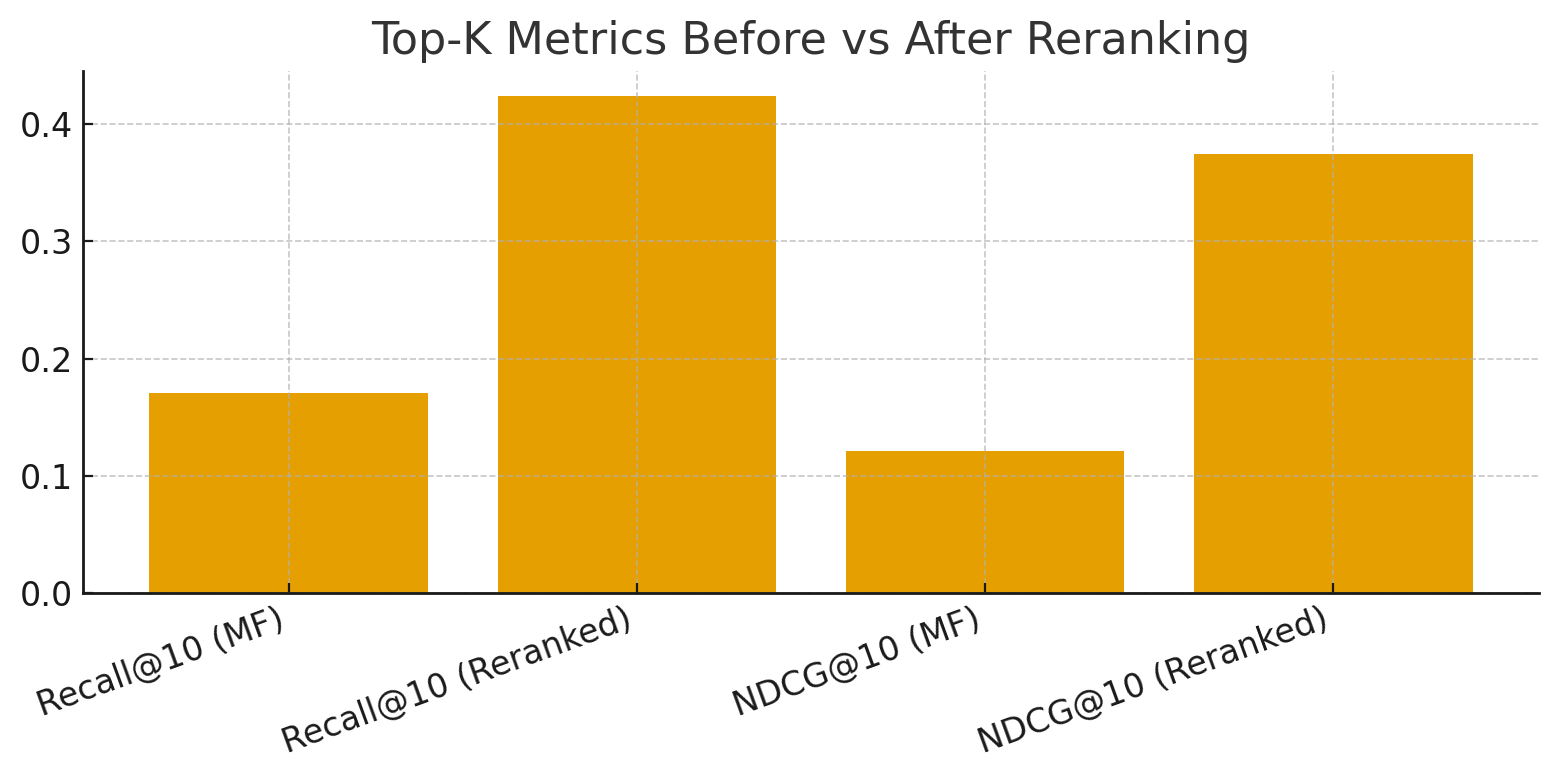

In [8]:

metrics = [mf_recall_k, rerank_recall_k, mf_ndcg_k, rerank_ndcg_k]
labels = ["Recall@10 (MF)", "Recall@10 (Reranked)", "NDCG@10 (MF)", "NDCG@10 (Reranked)"]

plt.figure(figsize=(8,4))
plt.bar(range(len(metrics)), metrics)
plt.xticks(range(len(metrics)), labels, rotation=20, ha='right')
plt.title("Top-K Metrics Before vs After Reranking")
plt.tight_layout()
plt.show()


## 8) Next Steps

- Add **temporal cross‑validation** and **calibration** checks for the reranker.
- Expand feature set (recency, novelty, diversity signals).
- Use a pairwise LTR objective (e.g., LambdaMART) for better ranking performance.
- Swap synthetic data for **MovieLens 100K** by loading `u.data`, `u.item`, etc., and reusing the same pipeline.
